In [1]:
import time
import os
import gc
import glob

import numpy as np
import pandas as pd
import xarray as xr

import dask
import dask.array as da
from dask import delayed, compute

import cftime
import pop_tools

# mask

In [10]:
# set up mask
grid_name = 'POP_gx1v7'
region_defs = {
    'subzero_Atlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 70.0], 'TLONG': [260.0, 360.0]}}
    ],
    'superzero_Atlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 70.0], 'TLONG': [0, 20.0]}}
    ],
    'Mediterranean': [
        {'match': {'REGION_MASK': [7]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [10.0, 70.0]}}
    ],
        'NordicSea': [
        {'match': {'REGION_MASK': [9]}, 'bounds': {'TLAT': [10.0, 70.0]}}
    ]
}
NA_mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic Mask')
NA_mask = NA_mask.sum('region')
NA_mask = NA_mask.roll(nlon=-100)

# Process CESM2 LENS2 ocean data by event conditions and compute composite timeseries
- Load event data and corresponding member files
- Apply regional mask using pop_tools
- Compute composite timeseries for different event conditions (increase/decrease)
- Save the resulting composites to NetCDF files in chunks



In [25]:
# Load data and group csv file by member
filename = f"change_point_indices_3_40_20.csv"
path = os.path.join(os.environ['HOME'], 'phase1_CONDA/publishable_code')
file = os.path.join(path, filename)
df = pd.read_csv(file)
grouped = df.groupby('Member')

FileNotFoundError: [Errno 2] No such file or directory: '/home/innag3580/phase1_CONDA/publishable_code/change_point_indices_3_40_20.csv'

In [ ]:
# Extract the variables from the filename
filename = os.path.basename(file)
parts = filename.replace('change_point_indices_', '').replace('.csv', '').split('_')
threshold_multiple = float(parts[0])
P1_len = int(parts[1])
P2_len = int(parts[2])

In [17]:
var_location = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/'

# easy variables
var_path = ['temp/temp_', 'salt/salt_', 'vvel/vvel_']#, 'shf/shf_', 'hmxl/hmxl_', 'taux/taux_', 'tauy/tauy_']
base_name = ['temp', 'salt', 'vvel']#, 'shf', 'hmxl', 'taux', 'tauy'
save_name = [f"{name}_{threshold_multiple}_{P1_len}_{P2_len}" for name in base_names]

temporary_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp_2/temporary/'
final_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp_2/composites/'

In [19]:
for var in var_path:
    
    iteration_count_decrease = 0
    iteration_count_increase = 0
    datasets_decrease = []
    datasets_increase = []
    print('started: ', var[5:-1])

    for member, group_data in grouped:
        member = f"{float(member):.3f}"
        print(member)
        file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/' + var + member + '.nc'
        ds_member = xr.open_dataset(file).isel(time=slice(0,3)).roll(nlon=-100).where(NA_mask == 1)
        print(member, ' started')
        
        break


started:  temp
1001.001
1001.001  started


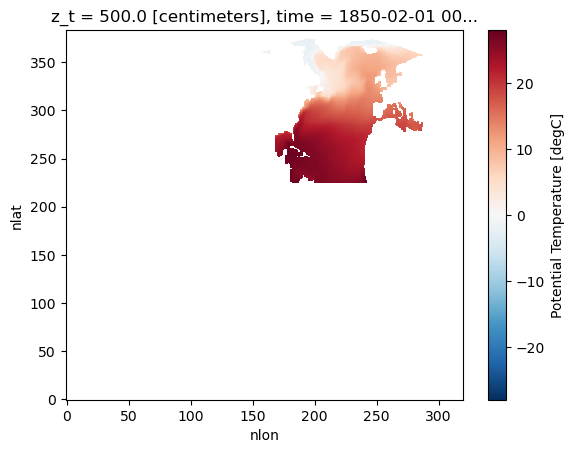

In [20]:
ds_member.TEMP.isel(time=0,z_t=0).plot()

In [18]:
# Process data in chunks
def compute_composite_timeseries(datasets):
    event_period = []
    for t in range((P1_len+P2_len)*12):
        event_time_step = []
        for ds_file in datasets:
            event_time_step.append(ds_file.isel(time=t))
        ds_comp = xr.concat(event_time_step, dim='file').mean(dim='file')
        event_period.append(ds_comp)
    composite_dataset = xr.concat(event_period, dim='time')
    return composite_dataset


def process_files(file_pattern, output_filename):
    #Create a list of file paths in the specified directory that match a given pattern
    file_list = [os.path.join(temporary_path, f) for f in os.listdir(temporary_path) if file_pattern in f]
    #opens each file with chunking along time dimension
    datasets = [xr.open_dataset(f, chunks={'time': 1}) for f in file_list]
    print(f'{file_pattern} datasets loaded')

    combined = xr.concat(datasets, dim='file')
    print(f'{file_pattern} datasets combined')

    average = combined.mean(dim='file')
    print(f'{file_pattern} datasets averaged')

    average.to_netcdf(os.path.join(final_path, output_filename))
    print(f'{file_pattern} dataset saved')

In [ ]:
i=0

for var in var_path:
    
    iteration_count_decrease = 0
    iteration_count_increase = 0
    datasets_decrease = []
    datasets_increase = []

    print('started: ', var[5:-1])

    for member, group_data in grouped:
        member = f"{float(member):.3f}"
        print(member)
        file = var_location + var + member + '.nc'
        ds_member = xr.open_dataset(file).roll(nlon=-100).where(NA_mask3d == 1)
        print(member, ' started')
        
        for event, condition in zip(group_data['Values'], group_data['Condition']):
            
            event_time = event * 12
            #period_start = max(event_time - (P1_len*12), 0)  # Ensure start is non-negative
            period_start = event_time - (P1_len*12)
            period_end = event_time + (P2_len*12)
            #if period_end > ds_member.sizes['time']:
            #    period_end = ds_member.sizes['time']  # Ensure end is within bounds
            time_slice = slice(period_start, period_end)
            
            try:
                #ds_chunk = ds_member.isel(time=time_slice).resample(time='A').mean(dim='time')
                # select event period
                ds_chunk = ds_member.isel(time=time_slice).resample(time='A')
                if condition == "increase":
                    datasets_increase.append(ds_chunk)
                elif condition == "decrease":
                    datasets_decrease.append(ds_chunk)
                ds_chunk.close()
            except ValueError as e:
                continue
            
            if len(datasets_decrease) >= 5:
                composite_dataset_decrease = compute_composite_timeseries(datasets_decrease)
                iteration_count_decrease += 1
                composite_dataset_decrease.to_netcdf(temporary_path + save_name[i] + '_decrease_' + str(iteration_count_decrease) + '.nc')
                composite_dataset_decrease.close()
                datasets_decrease = []
                print('saved decrease chunk: ', iteration_count_decrease)
            if len(datasets_increase) >= 5:
                composite_dataset_increase = compute_composite_timeseries(datasets_increase)
                iteration_count_increase += 1
                composite_dataset_increase.to_netcdf(temporary_path + save_name[i] + '_increase_' + str(iteration_count_increase) + '.nc')
                composite_dataset_increase.close()
                datasets_increase = []
                print('saved increase chunk: ', iteration_count_increase)
                
        ds_member.close()

    # Process remaining data
    if datasets_decrease:
        composite_dataset_decrease = compute_composite_timeseries(datasets_decrease)
        iteration_count_decrease += 1
        composite_dataset_decrease.to_netcdf(temporary_path + save_name[i] + '_decrease_' + str(iteration_count_decrease) + '.nc')
        composite_dataset_decrease.close()
        print('saved last decrease chunk')
    
    if datasets_increase:
        composite_dataset_increase = compute_composite_timeseries(datasets_increase)
        iteration_count_increase += 1
        composite_dataset_increase.to_netcdf(temporary_path  + save_name[i] + '_increase_' + str(iteration_count_increase) + '.nc')
        composite_dataset_increase.close()
        print('saved last increase chunk')
        
        
    file_pattern = save_name[i] + '_increase'
    process_files(file_pattern, save_name[i])
     
    file_pattern = save_name[i] + '_decrease'
    process_files(file_pattern, save_name[i])
                                                  
    i += 1

print('process complete')     


        

# Only get DJFM

In [11]:
i = '1281.018'

In [29]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/'
file_pattern = os.path.join(path, 'TEMP', f'*LE2-{i}*')
file_paths = sorted(glob.glob(file_pattern))
#file_paths = file_paths[:3]

In [22]:
def standardise_and_select_DJFM(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds.sel(time=ds['time.month'].isin([12, 1, 2, 3]))

def process_ds(ds):
    ds_first_FM  = ds.isel(time=slice(0,2)).coarsen(time=2, boundary='trim').mean()
    ds_DJFM = ds.isel(time=slice(2, None)).coarsen(time=4, boundary='trim').mean()
    return xr.concat([ds_first_FM, ds_DJFM], dim='time')


## just apply `standardise_and_select_DJFM` function

In [5]:
datasets = []
for file in file_paths[1:]:
    ds = xr.open_dataset(file, chunks={'time': 1})
    ds = standardise_and_select_DJFM(ds)
    datasets.append(ds)
    #break
    
#ds = xr.concat(datasets, dim='time')
ds = xr.merge(datasets)

/home/innag3580/.conda/envs/movie/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/innag3580/.conda/envs/movie/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


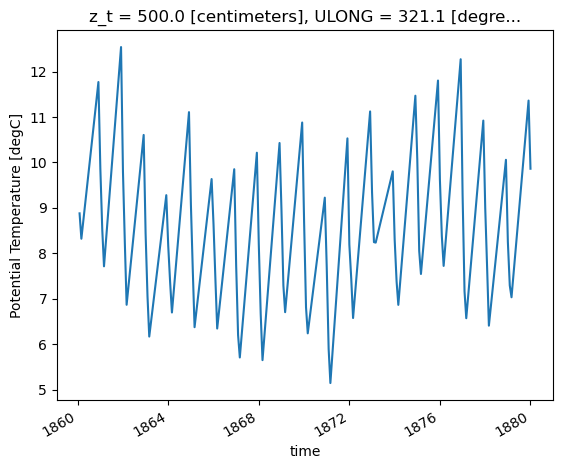

In [51]:
ds.TEMP.isel(z_t=0, nlat=320, nlon=0).plot()

## test coarsen and mean on Dataset

In [23]:
time = pd.date_range('2000-01-01', periods=24, freq='M')
data = np.random.rand(24, 5, 10)
ds = xr.Dataset({'TEMP': (['time', 'x', 'y'], data)}, coords={'time': time})

# Perform the operations
result = ds.isel(time=slice(2, None)).coarsen(time=4, boundary='trim').mean()

## reduce DJFM to means per year

In [6]:
#ds_first_FM = ds.isel(time=slice(0, 2)).mean(dim='time')
#ds_first_FM = ds.isel(time=slice(0, 2)).groupby('time').mean(dim='time')
#ds_first_FM = ds.isel(time=slice(0, 2)).mean(dim='time', keep_attrs=True).expand_dims('time')
#ds_first_FM = ds_first_FM.assign_coords(time=[0])
ds_first_FM  = ds.isel(time=slice(0,2)).coarsen(time=2, boundary='trim').mean()

In [7]:
ds_DJFM = ds.isel(time=slice(2, None)).coarsen(time=4, boundary='trim').mean()

/tmp/ipykernel_32715/469845825.py:1: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  ds_DJFM = ds.isel(time=slice(2, None)).coarsen(time=4, boundary='trim').mean()


## understand what is going wrong in the concatenating

In [8]:
# combine to get complete time series
ds_combined = xr.concat([ds_first_FM, ds_DJFM], dim='time')

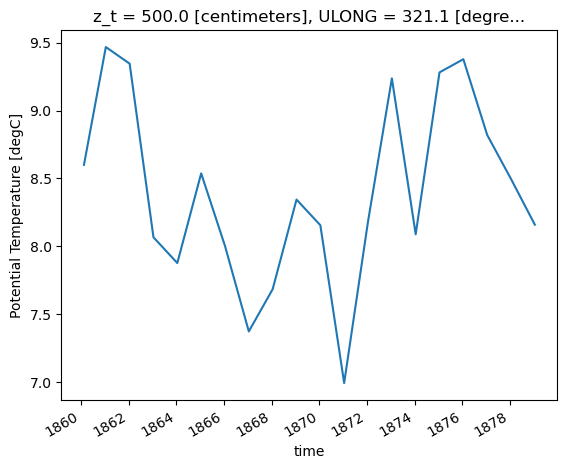

In [9]:
ds_combined.TEMP.isel(z_t=0, nlat=320, nlon=0).plot()

In [62]:
ds_final = process_ds(ds)

/tmp/ipykernel_150820/2131950955.py:18: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  ds_DJFM = ds.isel(time=slice(2, None)).coarsen(time=4, boundary='trim').mean()


In [63]:
ds_final

<xarray.Dataset>
Dimensions:                 (time: 20, moc_comp: 3, transport_comp: 5,
                             transport_reg: 2, z_t: 60, z_w: 60, nlat: 384,
                             nlon: 320, d2: 2, z_t_150m: 15, z_w_top: 60,
                             z_w_bot: 60, lat_aux_grid: 395, moc_z: 61)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * time                    (time) datetime64[ns] 1860-02-15T12:00:00 ... 187...
    ULONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, nlat,
                                nlon, d2
Data variables: (12/55)
    moc_components          (time, moc_comp) |S384 dask.array<chunksize=(1, 3), meta=np.ndarray>
    transport_components    (time, transport_comp) |S384 dask.array<chunksize=(1, 5), meta=np.ndarray>
    transport_regions       (time, transport_reg) |S384 dask.array<chunksize=(1, 2), meta=np.ndarray>
    dz                      (time, z_t) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    dzw                     (time, z_w) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    KMT                     (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ...                      ...
    salinity_factor         (time) float64 -0.00347 -0.00347 ... -0.00347
    sflux_factor            (time) float64 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    nsurface_t              (time) float64 8.61e+04 8.61e+04 ... 8.61e+04
    nsurface_u              (time) float64 8.297e+04 8.297e+04 ... 8.297e+04
    time_bound              (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BHISTsmbb.f09_g17.LE2-1281.018
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2021-01-08 at 18:19:46.6
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

# final insert

In [1]:
# Open datasets with Dask and filter for the specified months using combined preprocess function
#ds = xr.open_mfdataset(file_paths, chunks={'time': 1}, preprocess=standardise_and_select_DJFM, combine='by_coords')

datasets = []
for file in file_paths[1:]:
    ds = xr.open_dataset(file, chunks={'time': 12})
    ds = standardise_and_select_DJFM(ds)
    datasets.append(ds)
    
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds = xr.merge(datasets)
    ds = process_ds(ds)

# Apply mask
ds = ds.roll(nlon=-100).where(NA_mask == 1)


NameError: name 'file_paths' is not defined

In [ ]:
ds.TEMP.isel(z_t=0, nlat=320, nlon=200).plot()

# try three files

In [2]:
start_time = time.time()

### INITIALISATION ###

# Load data and group csv file by member
filename = f"change_point_indices_1.0_40_20.csv"
path = os.path.join(os.environ['HOME'], 'phase1_CONDA/publishable_code')
file = os.path.join(path, filename)
df = pd.read_csv(file)
#####              #####
##### INTERVENTION #####
#####              #####
df_first_three_rows = df.iloc[:3]
grouped = df_first_three_rows.groupby('Member')
#####              #####
##### INTERVENTION #####
#####     END      #####
#####              #####
#grouped = df.groupby('Member')

# Extract the variables from the filename
filename = os.path.basename(file)
parts = filename.replace('change_point_indices_', '').replace('.csv', '').split('_')
threshold_multiple = float(parts[0])
P1_len = int(parts[1])
P2_len = int(parts[2])

# set up mask
grid_name = 'POP_gx1v7'
region_defs = {
    'subzero_Atlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 70.0], 'TLONG': [260.0, 360.0]}}
    ],
    'superzero_Atlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 70.0], 'TLONG': [0, 20.0]}}
    ],
    'Mediterranean': [
        {'match': {'REGION_MASK': [7]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [10.0, 70.0]}}
    ],
        'NordicSea': [
        {'match': {'REGION_MASK': [9]}, 'bounds': {'TLAT': [10.0, 70.0]}}
    ]
}
NA_mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic Mask')
NA_mask = NA_mask.sum('region')
NA_mask = NA_mask.roll(nlon=-100)

# set up paths
base_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/'
temporary_path = '/Data/skd/scratch/innag3580/comp/temporary/'
final_path = '/Data/skd/scratch/innag3580/comp/composites/'

# easy variables
variables = ['TEMP', 
             'SALT', 'VVEL', 'SHF', 'HMXL', 'TAUX', 'TAUY']#, 'SIGMA_2']
base_name = ['temp', 
             'salt', 'vvel', 'shf', 'hmxl', 'taux', 'tauy']#, 'dens']
decrease_save_name = [f"decrease_{name}_{threshold_multiple}_{P1_len}_{P2_len}.nc" for name in base_name]
increase_save_name = [f"increase_{name}_{threshold_multiple}_{P1_len}_{P2_len}.nc" for name in base_name]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
### COMPUTATION ###

def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

def DJFM_average(ds):
    numeric_vars = {k: v for k, v in ds.data_vars.items() if np.issubdtype(v.dtype, np.number)}
    ds_numeric = xr.Dataset(numeric_vars, coords=ds.coords)
    ds_first_FM  = ds_numeric.isel(time=slice(0,2)).coarsen(time=2, boundary='trim').mean()
    ds_DJFM = ds_numeric.isel(time=slice(2, None)).coarsen(time=4, boundary='trim').mean()
    ds_combined = xr.concat([ds_first_FM, ds_DJFM], dim='time')
    return ds_combined

def prepare_ds_member(var, member_id):
    print('prepare_ds_member start')
    print('')
    file_pattern = os.path.join(base_path, var, f'*BHIST*LE2-{member_id}*.nc')
    file_paths = sorted(glob.glob(file_pattern))
    ds_member = xr.open_mfdataset(file_paths, chunks={'time': 120}, preprocess=standardise_time)
    ds_member = ds_member.sel(time=ds_member['time.month'].isin([12, 1, 2, 3]))
    ds_member = DJFM_average(ds_member)
    ds_member = ds_member.roll(nlon=-100).where(NA_mask == 1)
    
    return ds_member  

#def compute_composite_timeseries(datasets):
#####              #####
##### INTERVENTION #####
#####              #####
def compute_composite_timeseries(datasets, time):
    print('compute_composite_timeseries start')
    print(time.time())
    print('')
#####              #####
##### INTERVENTION #####
#####     END      #####
#####              #####
    event_period = []
    for t in range((P1_len+P2_len)):
        event_time_step = []
        for ds in datasets:
            event_time_step.append(ds.isel(time=t))
        ds_comp = xr.concat(event_time_step, dim='file').mean(dim='file')
        event_period.append(ds_comp)
        ds_comp.close()
    composite_dataset = xr.concat(event_period, dim='time')
    for ds in datasets:
        ds.close()
    return composite_dataset

#def clear_memory():
#####              #####
##### INTERVENTION #####
#####              #####
def clear_memory(time):
    print('clear_memory start')
    print(time.time())
    print('')
#####              #####
##### INTERVENTION #####
#####     END      #####
#####              #####
    global datasets_decrease, datasets_increase, composite_dataset_decrease, composite_dataset_increase
    del datasets_decrease[:]
    del datasets_increase[:]
    if 'composite_dataset_decrease' in globals():
        del composite_dataset_decrease
    if 'composite_dataset_increase' in globals():
        del composite_dataset_increase
    gc.collect()

#def final_composites(file_pattern, save_name):
#####              #####
##### INTERVENTION #####
#####              #####
def final_composites(file_pattern, save_name, time):
    print('final_composites start')
    print(time.time())
    print('')
#####              #####
##### INTERVENTION #####
#####     END      #####
#####              #####
    file_list = [os.path.join(temporary_path, f) for f in os.listdir(temporary_path) if file_pattern in f]
    datasets = [xr.open_dataset(f, chunks={'time': 1}) for f in file_list]
    combined = xr.concat(datasets, dim='file')
    average = combined.mean(dim='file')
    average.to_netcdf(os.path.join(final_path, save_name))
    print(f'{file_pattern} dataset saved')
    
    combined.close()
    average.close()
    for ds in datasets:
        ds.close()
            
#def remove_temp_files(file_pattern):
#####              #####
##### INTERVENTION #####
#####              #####
def remove_temp_files(file_pattern, time):
    print('remove_temp_files start')
    print(time.time())
    print('')
#####              #####
##### INTERVENTION #####
#####     END      #####
#####              #####
    pattern = os.path.join(temporary_path, f'*{file_pattern}*')
    files_to_delete = glob.glob(pattern)
    for file_path in files_to_delete:
        try:
            os.remove(file_path)
            print(f"Deleted file: {file_path}")
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")
            
def process_files(member, group_data, var):
#####              #####
##### INTERVENTION #####
#####              #####
#def process_files(member, group_data, var, time):
    print('process_files start')
#    print(time.time())
    print('')
#####              #####
##### INTERVENTION #####
#####     END      #####
#####              #####
    member_id = f"{float(member):.3f}"
    # standardise time, select and average over DJFM, 
    # and combine all files to one meber 
    ds_member = prepare_ds_member(var, member_id)
    print(member, ' started')
    # loop over all events per selected member
    for event, condition in zip(group_data['Values'], group_data['Condition']):
        # select details to one event
        
        event_time = event
        period_start = event_time - P1_len
        period_end = event_time + P2_len
        #time_slice = slice(period_start, period_end)
        #####              #####
        ##### INTERVENTION #####
        #####              #####
        time_slice = slice(period_start, period_start+3)
        #####              #####
        ##### INTERVENTION #####
        #####     END      #####
        #####              #####
        
        # add to list of selected members
        try:
            ds_period = ds_member.isel(time=time_slice)
            if condition == "Above":
                datasets_increase.append(ds_period)
            elif condition == "Below":
                datasets_decrease.append(ds_period)
            ds_period.close()
        except ValueError as e:
            continue
        # if list grows too long, average over list, 
        # and save in temporary storage
        if len(datasets_decrease) >= 3:
            #composite_dataset_decrease = compute_composite_timeseries(datasets_decrease)
            #####              #####
            ##### INTERVENTION #####
            #####              #####
            composite_dataset_decrease = compute_composite_timeseries(datasets_decrease, time)
            #####              #####
            ##### INTERVENTION #####
            #####     END      #####
            #####              #####
            composite_dataset_decrease.to_netcdf(temporary_path+file_pattern_decrease+str(count_decrease)+'.nc')
            count_decrease += 1
            composite_dataset_decrease.close()
            datasets_decrease = []
            print('saved decrease chunk: ', count_decrease)
        if len(datasets_increase) >= 3:
            #composite_dataset_increase = compute_composite_timeseries(datasets_increase)
            #####              #####
            ##### INTERVENTION #####
            #####              #####
            composite_dataset_increase = compute_composite_timeseries(datasets_increase, time)
            #####              #####
            ##### INTERVENTION #####
            #####     END      #####
            #####              #####
            composite_dataset_increase.to_netcdf(temporary_path+file_pattern_increase+str(count_increase)+'.nc')
            count_increase += 1
            composite_dataset_increase.close()
            datasets_increase = []
            print('saved increase chunk: ', count_increase)
    ds_member.close()
    # save final open datasets
    if datasets_decrease:
        #composite_dataset_decrease = compute_composite_timeseries(datasets_decrease)
        #####              #####
        ##### INTERVENTION #####
        #####              #####
        composite_dataset_decrease = compute_composite_timeseries(datasets_decrease, time)
        #####              #####
        ##### INTERVENTION #####
        #####     END      #####
        #####              #####
        count_decrease += 1
        composite_dataset_decrease.to_netcdf(temporary_path+file_pattern_decrease+str(count_decrease)+'.nc')
        composite_dataset_decrease.close()
        print('saved last decrease chunk')
    if datasets_increase:
        #composite_dataset_increase = compute_composite_timeseries(datasets_increase)
        #####              #####
        ##### INTERVENTION #####
        #####              #####
        composite_dataset_increase = compute_composite_timeseries(datasets_increase, time)
        #####              #####
        ##### INTERVENTION #####
        #####     END      #####
        #####              #####
        count_increase += 1
        composite_dataset_increase.to_netcdf(temporary_path+file_pattern_increase+str(count_increase)+'.nc')
        composite_dataset_increase.close()
        print('saved last increase chunk')
            

In [4]:
### OUTPUT ###

print(f"""
Composite compuation started
P1 length = {P1_len}
P2 length = {P2_len}
Threshold multiple = {threshold_multiple}
""")
    
i=0

var = 'TEMP'

# initiate 


file_pattern_decrease = decrease_save_name[i][:-3]
file_pattern_increase = increase_save_name[i][:-3]

print('started: ', var)

# select member
tasks = []
for member, group_data in grouped:
    # Create a delayed task for each member processing
    task = dask.delayed(process_files)(member, group_data, var)
    #####              #####
    ##### INTERVENTION #####
    #####              #####
    #task = dask.delayed(process_files)(member, group_data, var, time)
    #task = process_files(member, group_data, var, time)
    #####              #####
    ##### INTERVENTION #####
    #####     END      #####
    #####              #####
    tasks.append(task)

# Compute all the delayed tasks in parallel
dask.compute(*tasks)

#clear_memory()
#####              #####
##### INTERVENTION #####
#####              #####
clear_memory(time)
#####              #####
##### INTERVENTION #####
#####     END      #####
#####              #####

if count_decrease > 0:
    #final_composites(file_pattern_decrease, decrease_save_name[i])  
    #####              #####
    ##### INTERVENTION #####
    #####              #####
    final_composites(file_pattern_decrease, decrease_save_name[i], time)
    #####              #####
    ##### INTERVENTION #####
    #####     END      #####
    #####              #####
if count_increase > 0:
    #final_composites(file_pattern_increase, increase_save_name[i])
    #####              #####
    ##### INTERVENTION #####
    #####              #####
    final_composites(file_pattern_increase, increase_save_name[i], time)
    #####              #####
    ##### INTERVENTION #####
    #####     END      #####
    #####              #####

#clear_memory()
#remove_temp_files(file_pattern_decrease)       
#remove_temp_files(file_pattern_increase)   
#####              #####
##### INTERVENTION #####
#####              #####
clear_memory(time)
remove_temp_files(file_pattern_decrease, time)       
remove_temp_files(file_pattern_increase, time)   
#####              #####
##### INTERVENTION #####
#####     END      #####
#####              #####

print('process complete')     
end_time = time.time()
duration = end_time - start_time
print(f"Execution time: {duration} seconds")       


Composite compuation started
P1 length = 40
P2 length = 20
Threshold multiple = 1.0

started:  TEMP
process_files start

prepare_ds_member start



/home/innag3580/.conda/envs/movie/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tmp/ipykernel_285384/337073958.py:14: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this 

1001.001  started


UnboundLocalError: local variable 'datasets_increase' referenced before assignment

# check output

In [3]:
import matplotlib.pyplot as plt

In [15]:
var = 'SHF'

path = '/Data/skd/scratch/innag3580/comp/composites/'
file = f'Above_combined_{var}_3.0_40_20.nc'
#file = 'Above_combined_VVEL_3.0_40_20.nc'
ds = xr.open_dataset(path+file)

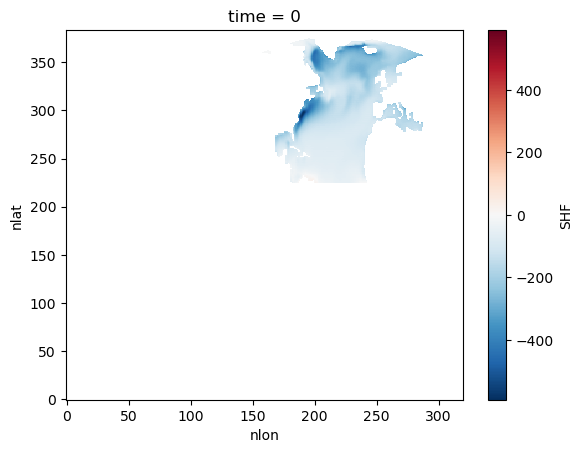

In [16]:
#ds[var].isel(time=0, z_t=0).plot()
ds[var].isel(time=0).plot()

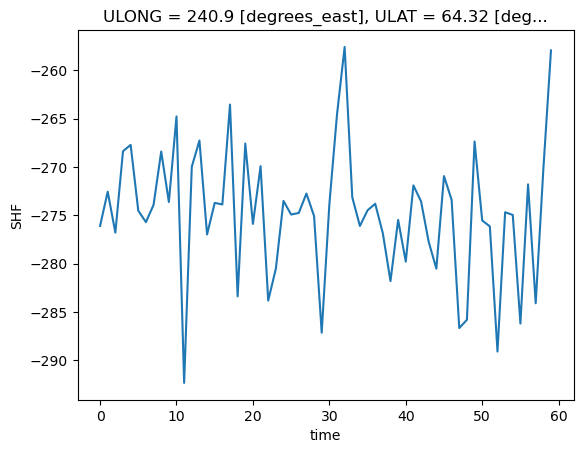

In [18]:
#ds[var].isel(z_t=0, nlat=340, nlon=240).plot()
ds[var].isel(nlat=340, nlon=240).plot()

# Combine files

In [2]:
# set up paths
base_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/'
temporary_path = '/Data/skd/scratch/innag3580/comp/temporary/'
final_path = '/Data/skd/scratch/innag3580/comp/composites/'

In [5]:
var = 'VVEL'
filename = 'change_point_indices_1.0_40_20.csv'

# Load data from change point analysis
path = os.path.join(os.environ['HOME'], 'phase1_CONDA/publishable_code')
file = os.path.join(path, filename)
df = pd.read_csv(file)

# Extract the variables from the filename
filename = os.path.basename(file)
parts = filename.replace('change_point_indices_', '').replace('.csv', '').split('_')
threshold_multiple = float(parts[0])
P1_len = int(parts[1])
P2_len = int(parts[2])

In [6]:
# Combine all 'Above' files
above_files = glob.glob(os.path.join(temporary_path, f'Above_*_{var}_{threshold_multiple}_{P1_len}_{P2_len}.nc'))
if above_files:
    combined_above = xr.open_mfdataset(above_files, concat_dim='new_dim', combine='nested').mean(dim='new_dim')
    combined_above.to_netcdf(os.path.join(final_path, f'Above_combined_{var}_{threshold_multiple}_{P1_len}_{P2_len}.nc'))
    for file_path in above_files:
        os.remove(file_path)
    print('deleted final above files')

deleted final above files


In [7]:
# Combine all 'Below' files
below_files = glob.glob(os.path.join(temporary_path, f'Below_*_{var}_{threshold_multiple}_{P1_len}_{P2_len}.nc'))
if below_files:
    combined_below = xr.open_mfdataset(below_files, concat_dim='new_dim', combine='nested').mean(dim='new_dim')
    combined_below.to_netcdf(os.path.join(final_path, f'Below_combined_{var}_{threshold_multiple}_{P1_len}_{P2_len}.nc'))
    for file_path in below_files:
        os.remove(file_path)
    print('deleted below files')

deleted below files


# subselect group

`file_pattern = os.path.join(base_path, var, f'*BHIST*LE2-{member_id}*.nc'`

In [2]:
import os
import glob

In [13]:
var = 'TEMP'
member_id = '1001'
base_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/'

In [14]:
file_patterns = [
    os.path.join(base_path, var, f'*{member_id}*.{var}.185001-185912.nc'),
    os.path.join(base_path, var, f'*{member_id}*.{var}.186001-186912.nc'),
    os.path.join(base_path, var, f'*{member_id}*.{var}.187001-187912.nc'),
    os.path.join(base_path, var, f'*{member_id}*.{var}.188001-188912.nc'),
    os.path.join(base_path, var, f'*{member_id}*.{var}.189001-189912.nc'),
    os.path.join(base_path, var, f'*{member_id}*.{var}.190001-190912.nc'),
    os.path.join(base_path, var, f'*{member_id}*.{var}.191001-191912.nc'),
    os.path.join(base_path, var, f'*{member_id}*.{var}.192001-192912.nc'),
    os.path.join(base_path, var, f'*{member_id}*.{var}.193001-193912.nc'),
    os.path.join(base_path, var, f'*{member_id}*.{var}.194001-194912.nc'),
    os.path.join(base_path, var, f'*{member_id}*.{var}.195001-195912.nc'),
    os.path.join(base_path, var, f'*{member_id}*.{var}.196001-196912.nc')]
filtered_files = []
for pattern in file_patterns:
    filtered_files.extend(glob.glob(pattern))
file_paths = sorted(filtered_files)

['/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.TEMP.185001-185912.nc', '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.TEMP.186001-186912.nc', '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.TEMP.187001-187912.nc', '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.TEMP.188001-188912.nc', '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.TEMP.189001-189912.nc', '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.TEMP.190001-190912.nc', '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.TEMP.191001-191912.nc', '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.TEMP.192001-192912.nc', '/Data/

In [12]:
glob.glob(os.path.join(base_path, var, f'*{member_id}*.{var}.185001-185912.nc'))

[]

# print test putput

In [4]:
import xarray as xr

In [7]:
#path = '/Data/skd/scratch/innag3580/comp/temporary/'
path = '/Data/skd/scratch/innag3580/comp/composites/'
file = 'Below_combined_VVEL_3.0_40_20.nc'

In [8]:
#ds = xr.open_dataset(path+file)
ds = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL/b.e21.BHISTcmip6.f09_g17.LE2-1231.002.pop.h.VVEL.197001-197912.nc')

HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 139622605674304:
  #000: H5F.c line 509 in H5Fopen(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1652 in H5F_open(): unable to read superblock
    major: File accessibilty
    minor: Read failed
  #002: H5Fsuper.c line 632 in H5F__super_read(): truncated file: eof = 481722141, sblock->base_addr = 0, stored_eof = 1861778084
    major: File accessibilty
    minor: File has been truncated


OSError: [Errno -101] NetCDF: HDF error: b'/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL/b.e21.BHISTcmip6.f09_g17.LE2-1231.002.pop.h.VVEL.197001-197912.nc'

In [64]:
ds

<xarray.Dataset>
Dimensions:                 (time: 60, z_t: 60, nlat: 384, nlon: 320, z_w: 60,
                             z_t_150m: 15, z_w_top: 60, z_w_bot: 60,
                             lat_aux_grid: 395, moc_z: 61)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * time                    (time) int64 0 1 2 3 4 5 6 ... 53 54 55 56 57 58 59
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
    ULONG                   (nlat, nlon) float64 ...
    ULAT                    (nlat, nlon) float64 ...
    TLONG                   (nlat, nlon) float64 ...
    TLAT                    (nlat, nlon) float64 ...
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/51)
    dz                      (time, z_t, nlat, nlon) float32 ...
    dzw                     (time, z_w, nlat, nlon) float32 ...
    KMT                     (time, nlat, nlon) float64 ...
    KMU                     (time, nlat, nlon) float64 ...
    REGION_MASK             (time, nlat, nlon) float64 ...
    UAREA                   (time, nlat, nlon) float64 ...
    ...                      ...
    fwflux_factor           (time, nlat, nlon) float64 ...
    salinity_factor         (time, nlat, nlon) float64 ...
    sflux_factor            (time, nlat, nlon) float64 ...
    nsurface_t              (time, nlat, nlon) float64 ...
    nsurface_u              (time, nlat, nlon) float64 ...
    VVEL                    (time, z_t, nlat, nlon) float32 ...

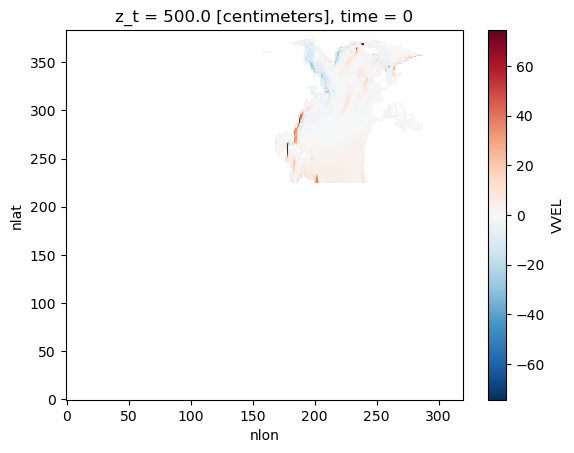

In [65]:
ds.VVEL.isel(time=0, z_t=0).plot()

# check selection process

In [34]:
import os
import pandas as pd

In [35]:
filename = 'change_point_indices_3.0_40_20_20.csv'
path = os.path.join(os.environ['HOME'], 'phase1_CONDA/publishable_code')
file = os.path.join(path, filename)
df = pd.read_csv(file)

In [36]:
print(df.head(3))

     Member  Values Condition
0  1001.001      72     Above
1  1001.001     143     Below
2  1031.002     119     Above


In [38]:
import glob

In [73]:
parts = filename.replace('change_point_indices_', '').replace('.csv', '').split('_')
threshold_multiple = float(parts[0])
P1_len = int(parts[1])
P2_len = int(parts[2])

In [74]:
temporary_path = '/Data/skd/scratch/innag3580/comp/temporary/'
file_paths = glob.glob(os.path.join(temporary_path, f'{threshold_multiple}_{P1_len}_{P2_len}_*.nc'))

In [75]:
file_paths

['/Data/skd/scratch/innag3580/comp/temporary/3.0_40_20_1.nc',
 '/Data/skd/scratch/innag3580/comp/temporary/3.0_40_20_3.nc']

In [80]:
above_files = []

for fp in file_paths:
    # Step 1: Split the file path by underscore
    split_fp = fp.split('_')
    
    print(split_fp)
    
    # Step 2: Get the last part and split by period
    last_part = split_fp[-1].split('.')
    
    print(last_part)
    
    # Step 3: Convert the first part to an integer
    index = int(last_part[0])
    
    print(index)
    
    # Step 4: Access the corresponding 'Condition' in df
    condition = df.loc[index, 'Condition']
    
    print(condition)
    
    # Step 5: Check if the condition is 'Above'
    if condition == 'Above':
        # Step 6: Append to above_files if condition is 'Above'
        above_files.append(fp)
        
    print()

['/Data/skd/scratch/innag3580/comp/temporary/3.0', '40', '20', '1.nc']
['1', 'nc']
1
Below

['/Data/skd/scratch/innag3580/comp/temporary/3.0', '40', '20', '3.nc']
['3', 'nc']
3
Below



In [77]:
above_files

['/Data/skd/scratch/innag3580/comp/temporary/3.0_40_20_1.nc',
 '/Data/skd/scratch/innag3580/comp/temporary/3.0_40_20_3.nc']

In [83]:
below_files = [
    fp for fp in file_paths
    if df.loc[int(fp.split('_')[-1].split('.')[0]), 'Condition'] == 'Below'
]

In [84]:
below_files

['/Data/skd/scratch/innag3580/comp/temporary/3.0_40_20_1.nc',
 '/Data/skd/scratch/innag3580/comp/temporary/3.0_40_20_3.nc']

In [85]:
combined_below = xr.open_mfdataset(below_files, concat_dim='new_dim', combine='nested').mean(dim='new_dim')

ValueError: zero-size array to reduction operation fmin which has no identity

# check saving process

In [1]:
import os
import glob

In [ ]:
above_files = glob.glob(os.path.join(temporary_path, f'Above_*_{var}_{threshold_multiple}_{P1_len}_{P2_len}_{period}.nc'))

# get netcdf

In [9]:
import xarray as xr

input_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.pop.h.TEMP.202501-203412.nc'
ds = xr.open_dataset(input_file)


In [12]:
sel_time='2025-08-01'
extracted_data = ds.sel(time=sel_time)

In [13]:
output_file = 'LENS2_temp_field.nc'
extracted_data.to_netcdf(output_file)